In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_squared_error
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tqdm

In [2]:
target_raw_1 = np.load('vel2_1_0.npy')
#target_raw_2 = np.load('vel4_1_0.npy')
#target_raw_3 = np.load('vel6_1_0.npy')
target_raw_4 = np.load('vel8_1_0.npy')
target_raw = np.concatenate([target_raw_1, #target_raw_2, target_raw_3, 
                             target_raw_4], axis=0).reshape((-1,70,70))
target_scaled = (target_raw - target_raw.min())/(target_raw.max() - target_raw.min())

In [3]:
data_raw_1 = np.load('seis2_1_0.npy')
#data_raw_2 = np.load('seis4_1_0.npy')
#data_raw_3 = np.load('seis6_1_0.npy')
data_raw_4 = np.load('seis8_1_0.npy')
data_raw = np.concatenate([data_raw_1, #data_raw_2, data_raw_3, 
                           data_raw_4], axis=0)#.reshape((-1,70,70))

t = np.linspace(0,999,1000)

dump = 1000*np.exp(- t / 150)
data_scaled = data_raw / dump.reshape(1, 1, 1000, 1)
data_scaled = (((data_scaled.min())-+ data_scaled) / (data_scaled.max() - data_scaled.min())+0.5)*2


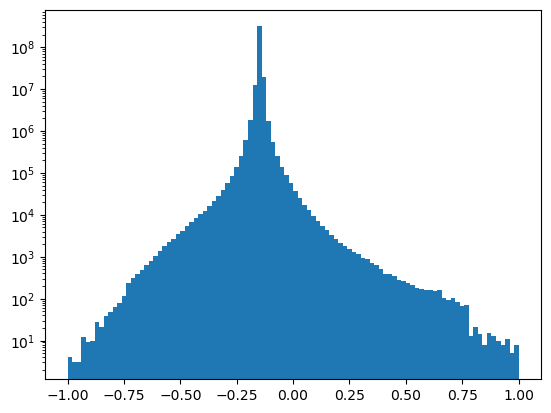

In [4]:
plt.hist(data_scaled.flatten(), bins=100, log=1);
#plt.plot(data_scaled[0,3].sum(-1))

In [7]:
data_scaled.shape, 16*16, 32*32

((1000, 5, 1000, 70), 256, 1024)

In [18]:
class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CNNAutoencoder, self).__init__()
        
        # Encoder
        k1 = 8
        k2 = 16
        k3 = 32
        k4 = 64
        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(5, k1, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k1),
            nn.ReLU(True),
            
            # Second convolutional block
            nn.Conv2d(k1, k2, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k2),
            nn.ReLU(True),
            
            # Third convolutional block
            nn.Conv2d(k2, k3, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k3),
            nn.ReLU(True),
            
            # Final encoding layer
            nn.Conv2d(k3, k4, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(k4),
            nn.ReLU(True),

            nn.Flatten(),
            
            nn.Linear(k4*125*9, latent_dim),
            #nn.BatchNorm1d(latent_dim),
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, k4*9*9),
            #nn.BatchNorm1d(k4*9*9),
            nn.ReLU(True),
            
            nn.Unflatten(1, (k4,9,9)),
            
            # First transposed conv block
            nn.ConvTranspose2d(k4, k3, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.BatchNorm2d(k3),
            nn.ReLU(True),
            
            # Second transposed conv block
            nn.ConvTranspose2d(k3, k2, kernel_size=3, stride=2, padding=1, output_padding=1),  # 9x9 -> 18x18
            nn.BatchNorm2d(k2),
            nn.ReLU(True),
            
            # Third transposed conv block
            nn.ConvTranspose2d(k2, k1, kernel_size=3, stride=2, padding=1),  # 18x18 -> 35x35
            nn.BatchNorm2d(k1),
            nn.ReLU(True),
            
            # Final transposed conv block
            nn.ConvTranspose2d(k1, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 35x35 -> 70x70
            nn.Sigmoid()  # Ensures output is between 0 and 1
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)


In [19]:
72000/64/125

9.0

In [29]:
model = CNNAutoencoder(latent_dim=4096)
loss_function = nn.MSELoss()
#loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
def verify_dimensions(model):
    print("Verifying network dimensions...")
    x = torch.randn(1,  5, 1000, 70)
    
    # Check encoder dimensions
    for i, layer in enumerate(model.encoder):
        x = layer(x)
        print(f"Encoder layer {i} ({layer.__class__.__name__}): output shape = {x.shape}")
    
    # Check decoder dimensions
    for i, layer in enumerate(model.decoder):
        x = layer(x)
        print(f"Decoder layer {i} ({layer.__class__.__name__}): output shape = {x.shape}")
    
    if x.shape[2] == 70 and x.shape[3] == 70:
        print("Success! Output dimensions match input dimensions (70x70)")
    else:
        print(f"Error: Output dimensions {x.shape[2]}x{x.shape[3]} don't match expected 70x70")

verify_dimensions(model)

Verifying network dimensions...
Encoder layer 0 (Conv2d): output shape = torch.Size([1, 8, 500, 35])
Encoder layer 1 (BatchNorm2d): output shape = torch.Size([1, 8, 500, 35])
Encoder layer 2 (ReLU): output shape = torch.Size([1, 8, 500, 35])
Encoder layer 3 (Conv2d): output shape = torch.Size([1, 16, 250, 18])
Encoder layer 4 (BatchNorm2d): output shape = torch.Size([1, 16, 250, 18])
Encoder layer 5 (ReLU): output shape = torch.Size([1, 16, 250, 18])
Encoder layer 6 (Conv2d): output shape = torch.Size([1, 32, 125, 9])
Encoder layer 7 (BatchNorm2d): output shape = torch.Size([1, 32, 125, 9])
Encoder layer 8 (ReLU): output shape = torch.Size([1, 32, 125, 9])
Encoder layer 9 (Conv2d): output shape = torch.Size([1, 64, 125, 9])
Encoder layer 10 (BatchNorm2d): output shape = torch.Size([1, 64, 125, 9])
Encoder layer 11 (ReLU): output shape = torch.Size([1, 64, 125, 9])
Encoder layer 12 (Flatten): output shape = torch.Size([1, 72000])
Encoder layer 13 (Linear): output shape = torch.Size([1, 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.12s/it]


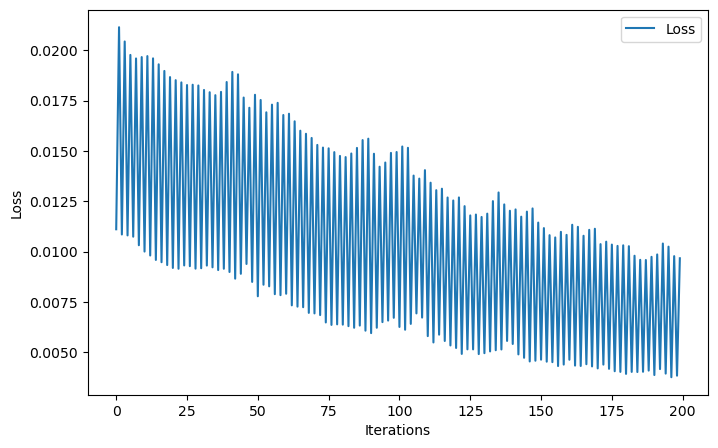

In [38]:
epochs = 100
outputs = []
losses = []
batch_size = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm.tqdm(range(epochs)):
    #for entry in target_scaled[0:700]:
    for i in range(0, int(len(data_scaled)*0.9), batch_size):
        entry = data_scaled[i:i+batch_size]
        target = target_scaled[i:i+batch_size]
        entry_tensor = torch.Tensor(entry.reshape(-1, 5, 1000,70)).to(device)
        target_tensor = torch.Tensor(target.reshape(-1, 1, 70,70)).to(device)
        reconstructed = model(entry_tensor)
        #print(reconstructed.shape)
        loss = loss_function(reconstructed, target_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, entry, reconstructed))
    #print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

#plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

0.01162013877183199


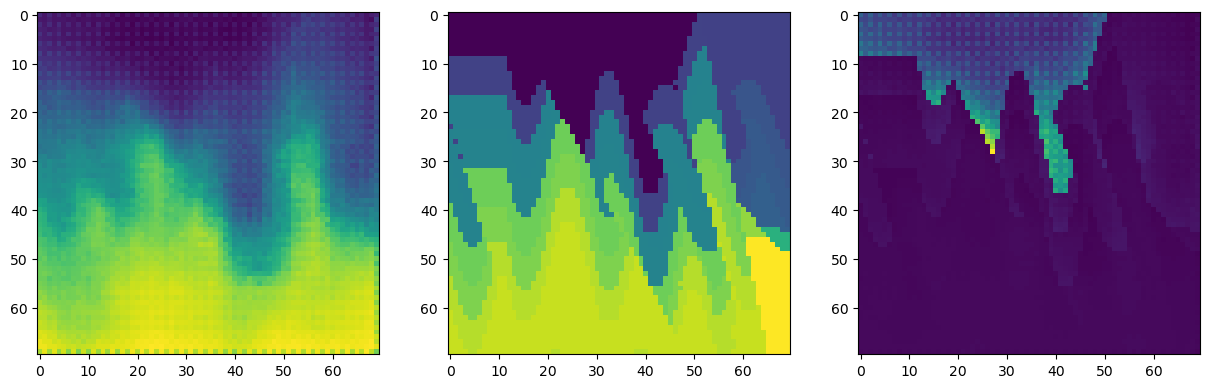

In [60]:
i = 987
entry_tensor = torch.Tensor(data_scaled[i].reshape(-1, 5, 1000,70)).to(device)
entry = model(entry_tensor).cpu().detach().numpy()
print(mean_squared_error(target_scaled[i], entry.reshape(70,70)))
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[2].imshow(entry.reshape(70,70)/target_scaled[i])
axs[1].imshow(target_scaled[i])
axs[0].imshow(entry.reshape(70,70))
